In [1]:
import os 
# cuda 
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import cv2



import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.nn.functional import relu


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms
from PIL import Image

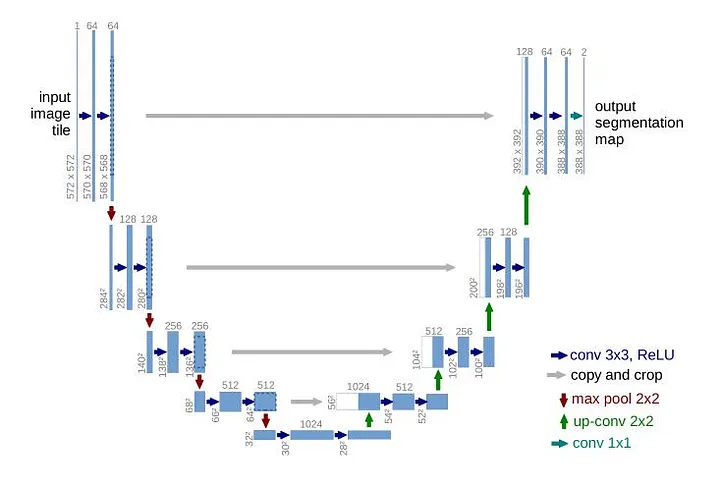

In [2]:
def viz (img):
    
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(15,15))
    plt.imshow(img)
    plt.show()

In [3]:
# Build model input image and output mask image

class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
            

        # input: 572x572x3
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)
        
    
    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))

        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        return self.outconv(xd42)
    

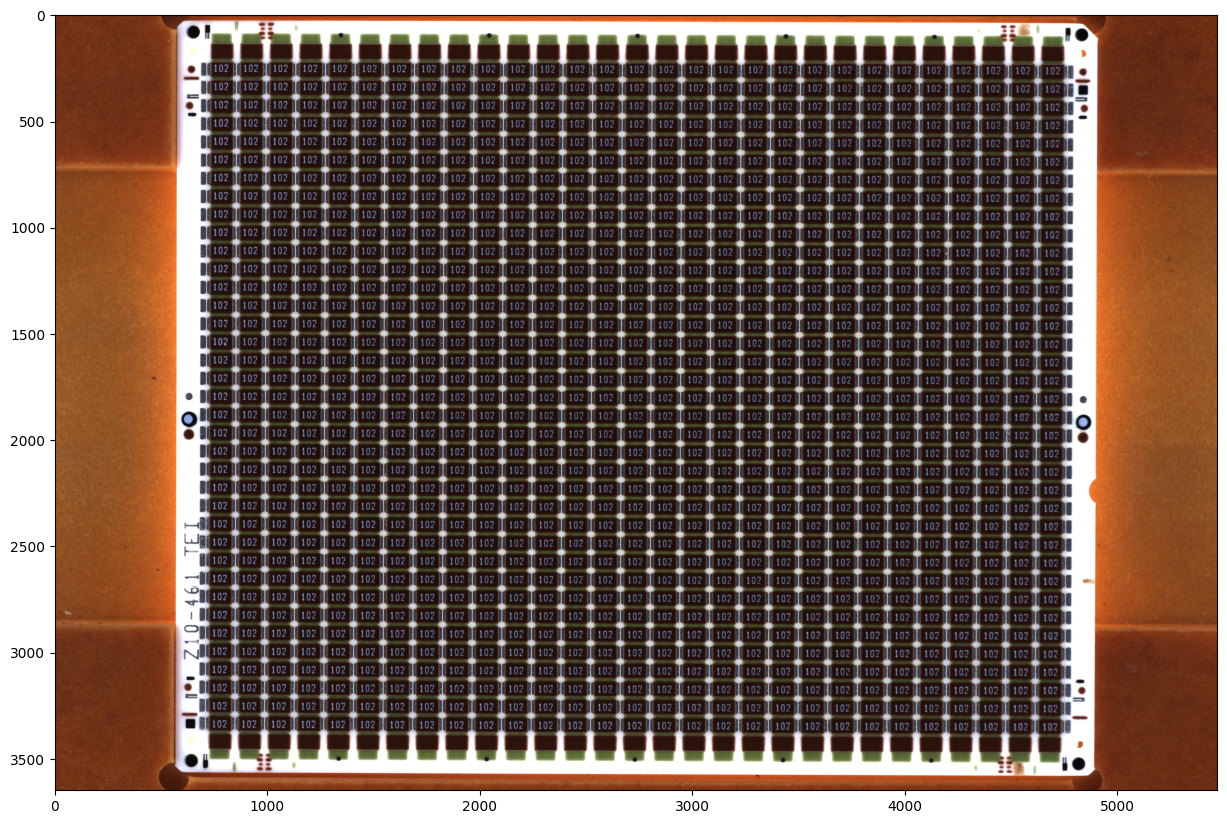

In [4]:

img  = r"/media/cow/User/Python/CNN_model/data/468.bmp"
img = cv2.imread(img)
viz(img)

[[0.02826695 0.03102221 0.0306133  ... 0.03048075 0.02784512 0.02388452]
 [0.02502587 0.0266852  0.0275179  ... 0.02855671 0.02988213 0.02401661]
 [0.02643647 0.02820244 0.0297697  ... 0.03060777 0.03100585 0.02607505]
 ...
 [0.02636353 0.02910418 0.03080129 ... 0.03094023 0.02951771 0.02565214]
 [0.02231209 0.02523209 0.02659594 ... 0.02483552 0.02706253 0.02337374]
 [0.01929938 0.01959132 0.01895142 ... 0.0193128  0.0203367  0.01855972]]


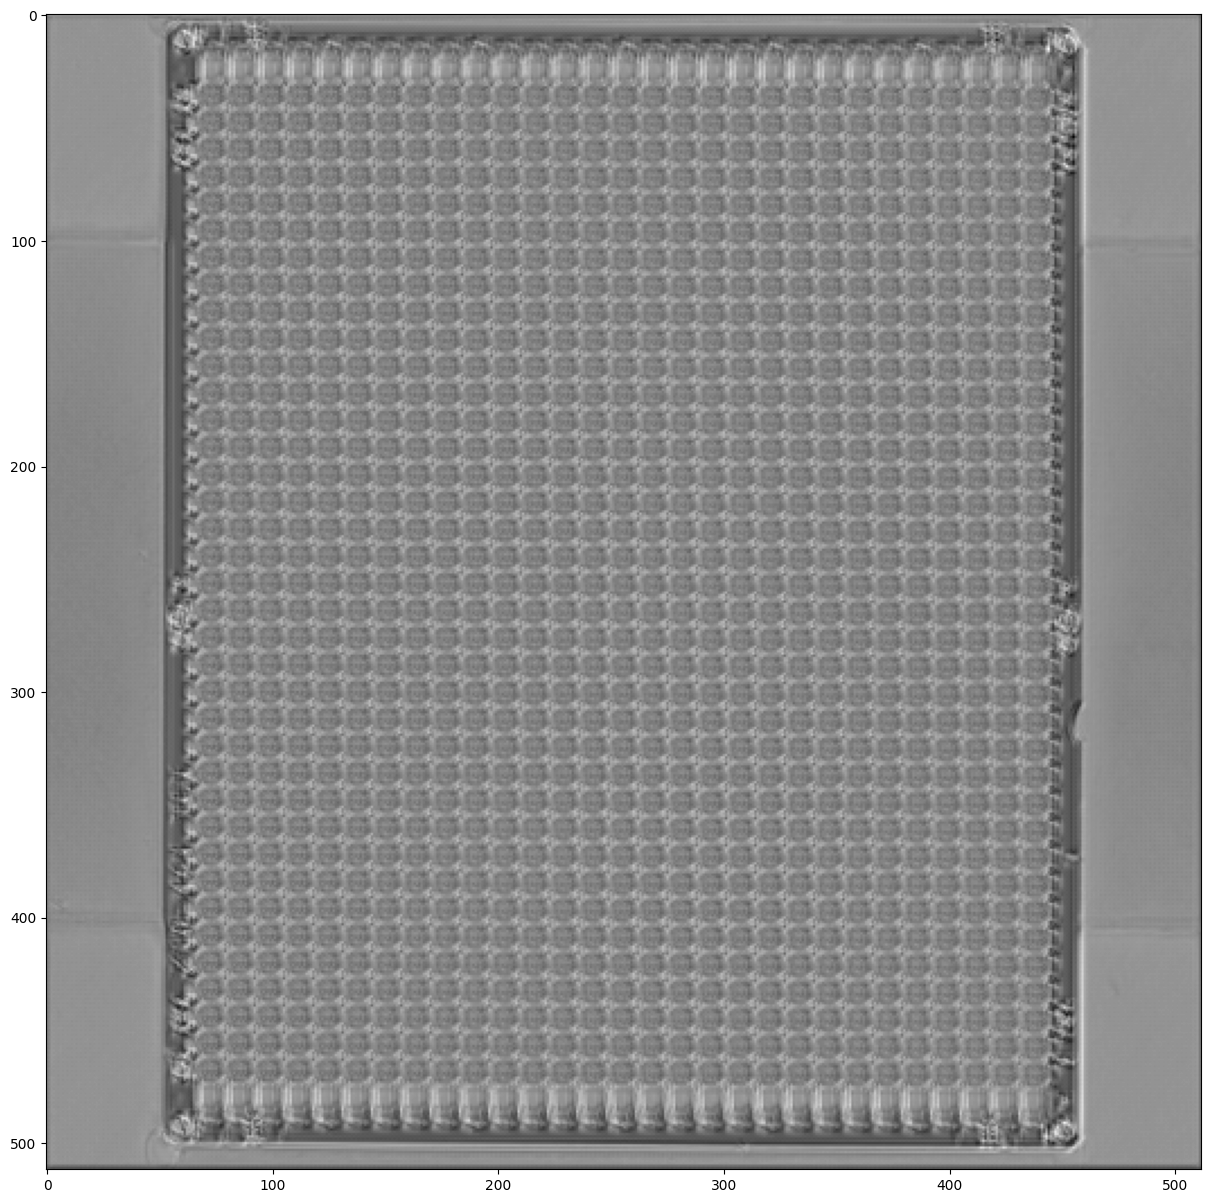

In [5]:



def load_image(image_path):
    image = Image.open(image_path).convert('RGB')  
    transform = transforms.Compose([
        transforms.Resize((512, 512)),  
        transforms.ToTensor(),  
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
    ])
    image = transform(image).unsqueeze(0)  
    return image

def show_output(output):
    output = output.squeeze().detach().cpu().numpy() 
    print(output)
    plt.figure(figsize=(15, 15))
    plt.imshow(output, cmap='gray')  
    plt.show()

n_classes = 1  
model = UNet(n_classes)

model.eval()

image_path = r"/media/cow/User/Python/CNN_model/data/468.bmp"
image = load_image(image_path=image_path)

with torch.no_grad(): 
    output = model(image)

show_output(output)



In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import random_split

class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform_image=None, transform_mask=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform_image = transform_image
        self.transform_mask = transform_mask
        self.images = [file for file in os.listdir(image_dir) if file.endswith(".bmp")]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".bmp", "_mask.png"))

        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)  # Convert to RGB
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        
        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)
        
        return image, mask


# Paths
image_path = r"/media/cow/User/Python/CNN_model/data"
mask_path = r"/media/cow/User/Python/CNN_model/output"
image_dir = os.path.join(image_path)
mask_dir = os.path.join(mask_path)

# Transformations
transform_image = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_mask = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

# Dataset
dataset = CustomDataset(image_dir, mask_dir, transform_image=transform_image, transform_mask=transform_mask)

# Splitting Dataset
train_size = int(0.5 * len(dataset))
val_test_size = len(dataset) - train_size
val_size = int(0.5 * val_test_size)
test_size = val_test_size - val_size

train_dataset, val_test_dataset = random_split(dataset, [train_size, val_test_size])
val_dataset, test_dataset = random_split(val_test_dataset, [val_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

len(train_dataset), len(val_dataset), len(test_dataset)

(17, 8, 9)

In [54]:
import tqdm


# Check CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model setup
model = UNet(2).to(device) 

# Define loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
epochs = 10


for epoch in range(epochs):
    model.train()
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")
    epoch_loss = 0.0
    for batch_index , (images, masks) in enumerate(loop):
        images, masks = images.to(device), masks.to(device).long()  # Ensure masks are long for CrossEntropyLoss
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        loop.set_postfix(loss=epoch_loss / (batch_index + 1))
    

Using device: cuda


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 3.80 GiB of which 17.44 MiB is free. Including non-PyTorch memory, this process has 3.70 GiB memory in use. Of the allocated memory 3.61 GiB is allocated by PyTorch, and 2.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [8]:
# # make mask from labelme




# import json
# import numpy as np
# from PIL import Image, ImageDraw
# import os
# import cv2

# def create_mask_from_labelme(json_file, output_mask_path, img_shape):
#     with open(json_file) as f:
#         data = json.load(f)

#     mask = np.zeros((img_shape[1], img_shape[0]), dtype=np.uint8)

#     for shape in data['shapes']:
#         if shape['shape_type'] == 'polygon':
#             points = shape['points']
#             points = np.array(points)

#             center_x = np.mean(points[:, 0])
#             center_y = np.mean(points[:, 1])

#             shrink_amount = 12

#             new_points = []
#             for point in points:
#                 dx = point[0] - center_x
#                 dy = point[1] - center_y
                
#                 distance = np.sqrt(dx**2 + dy**2)
#                 if distance != 0:
#                     factor = (distance - shrink_amount) / distance
#                     new_x = center_x + dx * factor
#                     new_y = center_y + dy * factor
#                 else:
#                     new_x, new_y = point  

#                 new_points.append([new_x, new_y])

#             new_points = np.array(new_points)

#             pil_mask = Image.fromarray(mask)
#             draw = ImageDraw.Draw(pil_mask)

#             class_id = 256
            
#             new_points = [(int(x), int(y)) for x, y in new_points]
#             draw.polygon(new_points, outline=class_id, fill=class_id)

#             mask = np.array(pil_mask)

#     mask_img = Image.fromarray(mask)
#     mask_img.save(output_mask_path)

# for file in os.listdir(r"D:\Python\CNN_model\data"):
#     if file.endswith(".json"):
#         json_file = os.path.join(r"D:\Python\CNN_model\data", file)
#         output_mask_path = os.path.join(r"D:\Python\CNN_model\output", file.replace(".json", "_mask.png"))
        
#         img = cv2.imread(os.path.join(r"D:\Python\CNN_model\data", file.replace(".json", ".bmp")))
        
#         img_shape = img.shape[:2]  
#         img_shape = (img_shape[1], img_shape[0])
        
#         create_mask_from_labelme(json_file, output_mask_path, img_shape)
#         print(f"Generated mask for {file} saved to {output_mask_path}")


In [9]:

# for file in os.listdir(r"D:\Python\CNN_model\output"):
#     if file.endswith(".png"):
#         img = cv2.imread(os.path.join(r"D:\Python\CNN_model\output", file))
#         img = cv2.resize(img, (512, 512))
#         cv2.imwrite(os.path.join(r"D:\Python\CNN_model\output", file), img)
#         print(f"Resized mask {file} to 512x512")